# Deep Learning with pytorch: Generative Adversial Network.

- **Problem Statement**: To Build DCGAN to generate handwritten digits
- **Objectives**:
    - DataLoader to load dataset into batches
    - Create Discrimnator Network
    - Create Generator Network
    - Create Training loop to train GAN model.
    

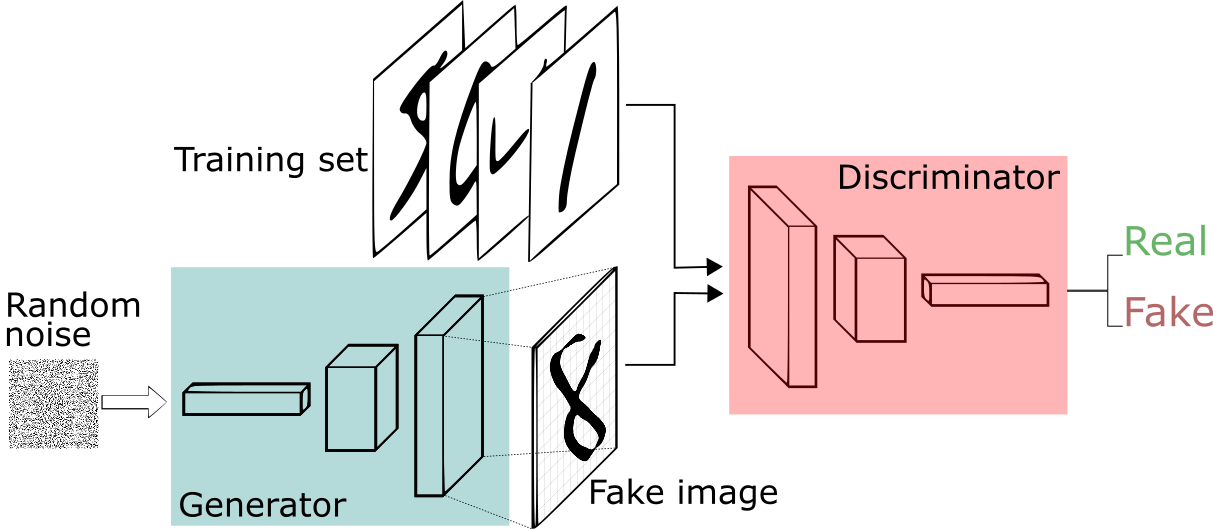

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Configurations

In [2]:
device = 'cuda' #to transfer image to gpu use image.to(device)
batch_size = 128
noise_dim = 64 #shape of the Random Noise vector, use for genrator model

#optimizers params
lr= 0.0002
beta_1 = 0.5
beta_2 = 0.99

#training variables
epochs = 20

In [3]:
from torchvision import datasets,transforms as T

In [4]:
train_augs = T.Compose([T.RandomRotation((-20,20)),
                        T.ToTensor()])

In [5]:
trainset = datasets.MNIST('GAN_DL_Pytorch/', download= True, train=True, transform= train_augs)

In [9]:
# import os
# os.getcwd()

In [6]:
# a, b=trainset[0]
# a.shape, a.squeeze().shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

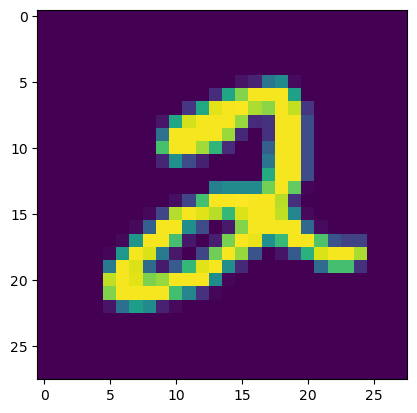

In [7]:
image, label = trainset[5]
plt.imshow(image.squeeze())

In [8]:
print('total images present in trainset are: ', len(trainset))

total images present in trainset are:  60000


# Load Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle= True)

In [11]:
print('Total No. of batches in trainloader: ', len(trainloader))

Total No. of batches in trainloader:  469


In [12]:
# lets load one batch
data_Iter = iter(trainloader)
images, _ = next(data_Iter)
images.shape

torch.Size([128, 1, 28, 28])

- tot. no. off batches we got is 469
- each batch containes noofimages= 128, c=1, h=28, w=28

In [13]:
## below function is used to plot some of images from the batch.
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu() #we remove the grad
    img_grid = make_grid(unflat_img[:num_images], nrow=4) # pass to the make grid fun, which forms the grid of images
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

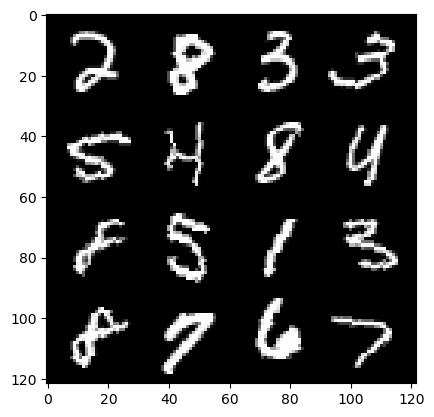

In [14]:
show_tensor_images(images, 16)

# Discriminator Network
- **Discriminator** is a classifier that distinquises real data created  by generator.
- The discriminator looks at real images and generated images separately. It outputs the probability that the input image is real. 

In [15]:
from torch import nn
from torchsummary import summary # pip3 install torchsummary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [17]:
def get_discriminator(in_c, out_c, kernel_S, s):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_S, stride= s),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2)
    )

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_1 = get_discriminator(1, 16, (3,3), 2)
        self.block_2 = get_discriminator(16, 32, (5,5), 2)
        self.block_3 = get_discriminator(32, 64, (5,5), 2)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64,out_features=1)
    
    def forward(self, images):
        x= self.block_1(images)
        x= self.block_2(x)
        x= self.block_3(x)
        
        x= self.flatten(x)
        x= self.linear(x)
        
        return x

In [19]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Generator Network

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [21]:
# conv2d decrease the size while convTranspose2d inc. the size
def get_generator(in_c, out_c, kernel_S, s, final_block =False):
    if final_block == True:
        return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_S, stride= s),
        nn.Tanh()
        )
    
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_S, stride= s),
        nn.BatchNorm2d(out_c),
        nn.ReLU()
    )

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.noise_dim = noise_dim
        self.block_1 = get_generator(noise_dim, 256, (3,3), 2)
        self.block_2 = get_generator(256, 128, (4,4), 1)
        self.block_3 = get_generator(128, 64, (3,3), 2)
        
        self.block_4 = get_generator(64, 1, (4,4), 2, final_block = True)
    
    def forward(self, rand_noise_vec):
        ## (bs, noise_dim) --> (bs, noise_dim, 1, 1)
        x = rand_noise_vec.view(-1, self.noise_dim, 1,1) #reshaping the noise
        
        x= self.block_1(x)
        x= self.block_2(x)
        x= self.block_3(x)
        
        x= self.block_4(x)
        
        return x

In [28]:
G = Generator()
G.to(device)

summary(G, input_size=(1,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [29]:
# Randomly initialized weight to Normal Weights

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [30]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Loss Function and Optimizer

In [32]:
def real_loss(disc_preds):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_preds)
    Loss = criterion(disc_preds, ground_truth)
    return Loss

def fake_loss(disc_preds):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_preds)
    Loss = criterion(disc_preds, ground_truth)
    return Loss

In [34]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas =(beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas =(beta_1,beta_2))

# Training Loop

In [42]:
# now that we have our architecture, lets train our model.
def train_model(epochs):
    for epoch in range(epochs):
        train_D_loss = 0.0
        train_G_loss = 0.0
        
        for real_img, _ in tqdm(trainloader): # real_img is xs     
            real_img = real_img.to(device)
            noise = torch.randn(batch_size, noise_dim, device= device)
            
            # Discriminator network
            D_opt.zero_grad()
            
            fake_img = G(noise)
            D_preds = D(fake_img)
            D_fake_loss = fake_loss(D_preds)
            
            D_preds = D(real_img)
            D_real_loss = real_loss(D_preds)
            
            D_loss = (D_fake_loss + D_real_loss)/ 2
            
            train_D_loss += D_loss.item() 
        
            D_loss.backward()# gradient find
            D_opt.step()#update params
            
            # Generator Network
            G_opt.zero_grad()
            
            noise = torch.randn(batch_size, noise_dim, device= device)
            
            fake_img = G(noise)
            D_preds = D(fake_img)
            G_loss = real_loss(D_preds)
            
            train_G_loss += G_loss.item()  
        
            G_loss.backward()# gradient find
            G_opt.step()#update params
        
        train_D_loss /=len(trainloader) #overall D loss of ith epoch
        train_G_loss /=len(trainloader) #overall G loss of ith epoch
        
            
        print(f'| Epoch: {(epoch+1):02} | Train_D_loss: {train_D_loss:.3f} | Train_G_loss: {train_G_loss:.3f}')
        
        # lets show some of the generated images
        show_tensor_images(fake_img)

100%|█████████████████████████████████████████| 469/469 [00:24<00:00, 19.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 01 | Train_D_loss: 0.685 | Train_G_loss: 0.701


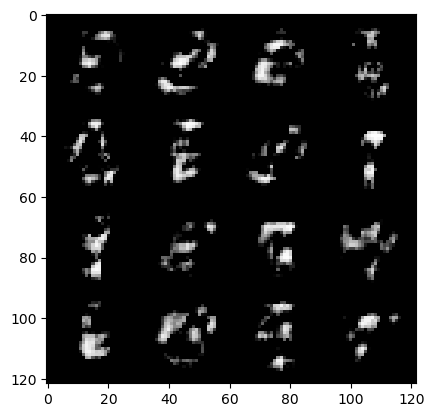

100%|█████████████████████████████████████████| 469/469 [00:22<00:00, 20.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 02 | Train_D_loss: 0.663 | Train_G_loss: 0.730


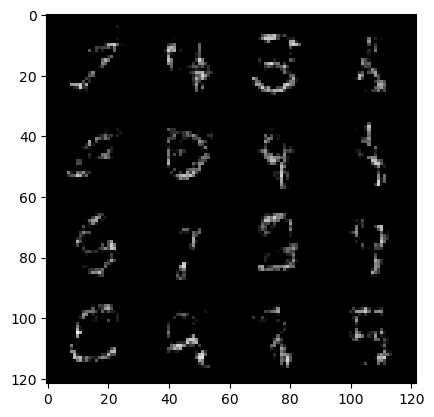

100%|█████████████████████████████████████████| 469/469 [00:22<00:00, 21.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 03 | Train_D_loss: 0.588 | Train_G_loss: 0.818


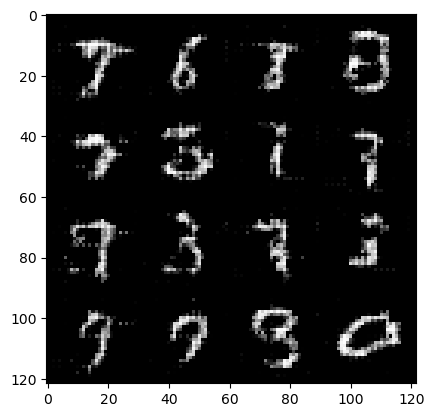

100%|█████████████████████████████████████████| 469/469 [00:21<00:00, 21.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 04 | Train_D_loss: 0.537 | Train_G_loss: 0.899


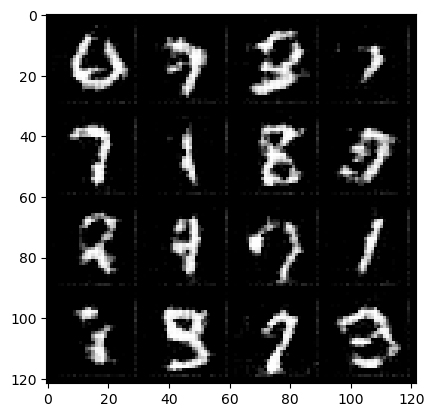

100%|█████████████████████████████████████████| 469/469 [00:21<00:00, 21.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 05 | Train_D_loss: 0.521 | Train_G_loss: 0.945


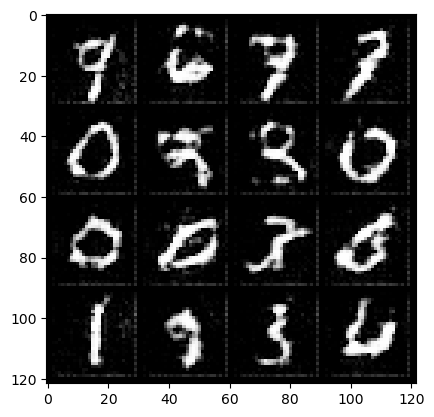

100%|█████████████████████████████████████████| 469/469 [00:21<00:00, 21.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 06 | Train_D_loss: 0.514 | Train_G_loss: 0.976


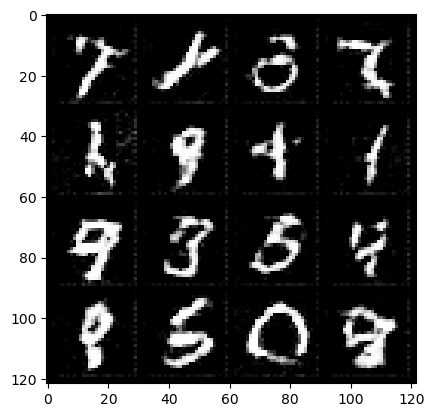

100%|█████████████████████████████████████████| 469/469 [00:22<00:00, 21.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 07 | Train_D_loss: 0.527 | Train_G_loss: 0.977


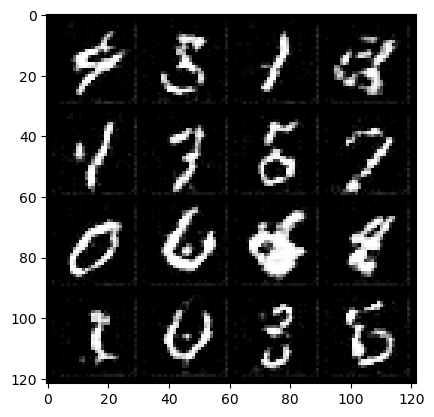

100%|█████████████████████████████████████████| 469/469 [00:21<00:00, 21.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 08 | Train_D_loss: 0.548 | Train_G_loss: 0.958


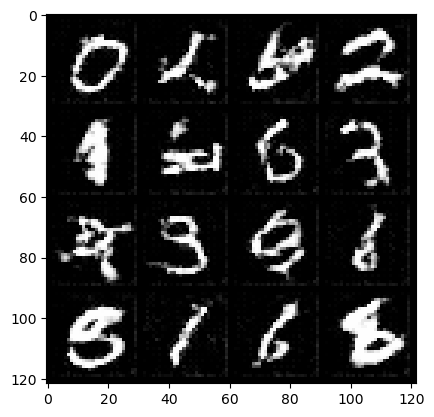

100%|█████████████████████████████████████████| 469/469 [00:21<00:00, 21.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 09 | Train_D_loss: 0.568 | Train_G_loss: 0.937


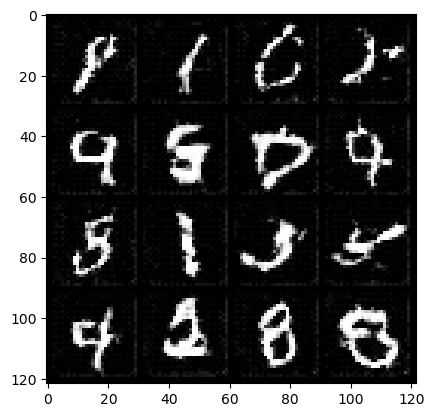

100%|█████████████████████████████████████████| 469/469 [00:22<00:00, 21.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 10 | Train_D_loss: 0.587 | Train_G_loss: 0.915


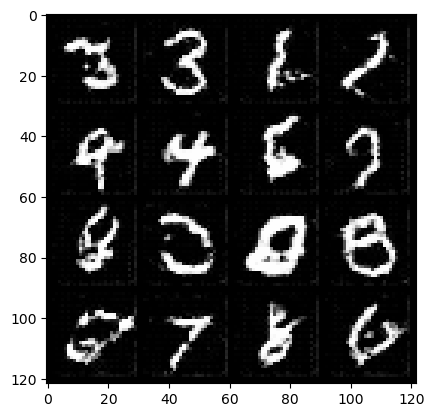

100%|█████████████████████████████████████████| 469/469 [00:22<00:00, 20.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 11 | Train_D_loss: 0.598 | Train_G_loss: 0.900


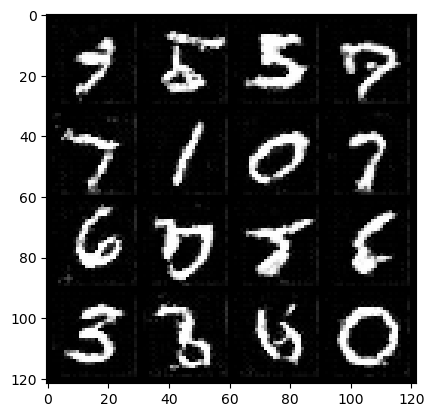

100%|█████████████████████████████████████████| 469/469 [00:22<00:00, 20.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 12 | Train_D_loss: 0.606 | Train_G_loss: 0.886


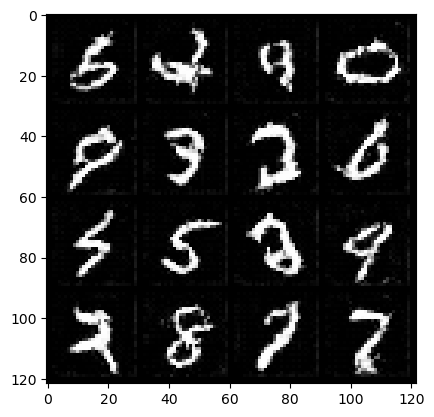

100%|█████████████████████████████████████████| 469/469 [00:22<00:00, 20.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 13 | Train_D_loss: 0.611 | Train_G_loss: 0.880


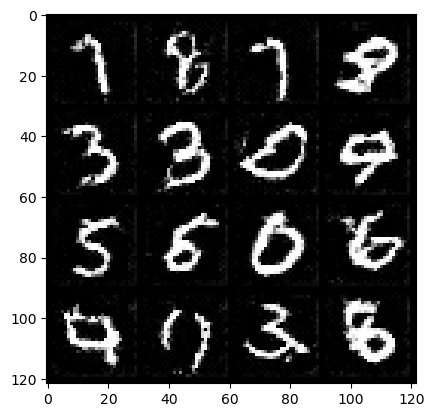

100%|█████████████████████████████████████████| 469/469 [00:23<00:00, 19.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 14 | Train_D_loss: 0.615 | Train_G_loss: 0.874


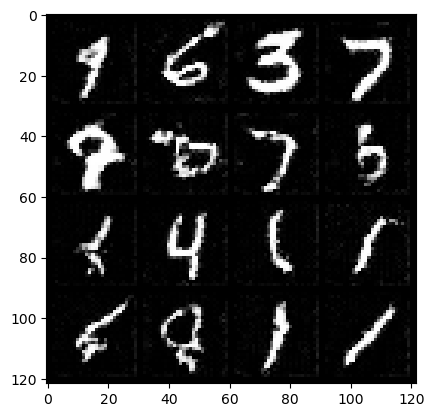

100%|█████████████████████████████████████████| 469/469 [00:23<00:00, 20.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 15 | Train_D_loss: 0.618 | Train_G_loss: 0.869


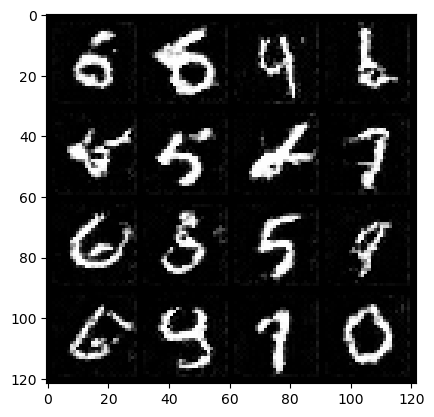

100%|█████████████████████████████████████████| 469/469 [00:24<00:00, 19.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 16 | Train_D_loss: 0.621 | Train_G_loss: 0.868


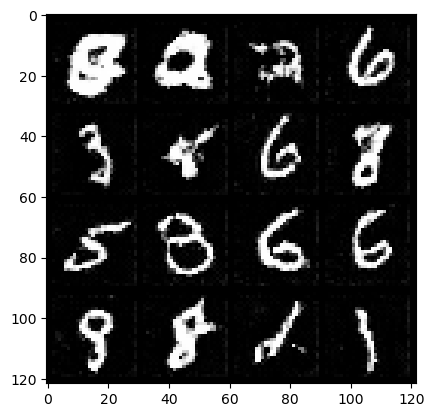

100%|█████████████████████████████████████████| 469/469 [00:25<00:00, 18.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 17 | Train_D_loss: 0.623 | Train_G_loss: 0.864


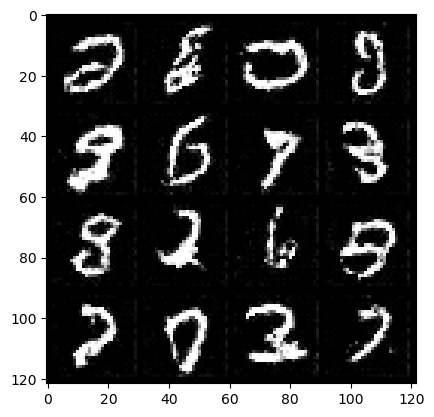

100%|█████████████████████████████████████████| 469/469 [00:25<00:00, 18.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 18 | Train_D_loss: 0.625 | Train_G_loss: 0.860


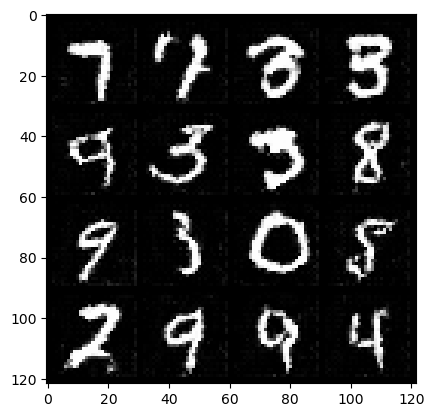

100%|█████████████████████████████████████████| 469/469 [00:26<00:00, 17.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 19 | Train_D_loss: 0.627 | Train_G_loss: 0.858


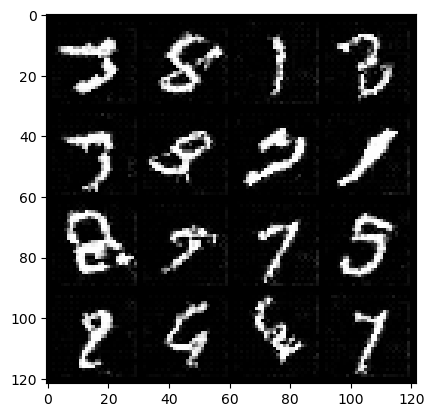

100%|█████████████████████████████████████████| 469/469 [00:25<00:00, 18.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


| Epoch: 20 | Train_D_loss: 0.629 | Train_G_loss: 0.857


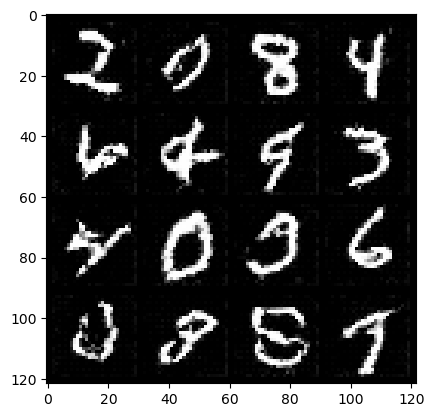

In [43]:
from tqdm import tqdm
train_model(epochs)